##import

In [1]:
%tensorflow_version 2.x
from keras.datasets import imdb
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [1]:
seq_length = 10 # length of sequence for a training example
epoch = 15
train_model_percentage = 80

In [3]:
f = open("473.astar-s0.txt", 'r')

In [4]:
unique_instr_id = list()
cycle_count = list()
load_address = list()
instr_pointer_load = list()
llc_hit_miss = list()

f.seek(0, 0)
while True:
  line = f.readline()
  if not line: break
  split_line = line.split(', ')
  unique_instr_id.append(split_line[0])
  cycle_count.append(split_line[1])
  load_address.append(split_line[2])
  instr_pointer_load.append(split_line[3])
  llc_hit_miss.append(split_line[4][:-1])

for i in range(len(load_address)):
  load_address[i] = int(int(load_address[i], 16)/64)

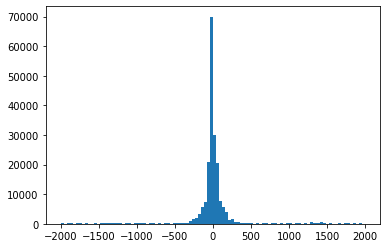

[687, 312, 445, 755, 611, 566, 515, 584, 334, 698, 576, 584, 544, 164, 903, 564, 582, 532, 1000, 0, 969, 436, 1000, 591, 564, 0, 1000, 0, 531, 1000, 586, 532, 510, 586, 0, 1000, 618, 564, 513, 532, 583, 516, 564, 564, 564, 597, 532, 532, 0, 1000, 751, 564, 602, 532, 532, 526, 564, 563, 0, 1000, 564, 602, 532, 532, 404, 622, 564, 0, 1000, 564, 597, 531, 437, 370, 768, 564, 589, 532, 571, 461, 603, 301, 763, 589, 0, 1000, 0, 1000, 1000, 0, 532, 347, 685, 1000, 0, 781, 0, 1000, 563, 501]
4363500794111
[[ 687  312  445 ...  334  698  576]
 [ 312  445  755 ...  698  576  584]
 [ 445  755  611 ...  576  584  544]
 ...
 [1000    0  413 ...  554  501 1000]
 [   0  413 1000 ...  501 1000  499]
 [ 413 1000  798 ... 1000  499    0]]
[[ 687  312  445 ...  584  334  698]
 [ 312  445  755 ...  334  698  576]
 [ 445  755  611 ...  698  576  584]
 ...
 [1000    0  413 ...    0  554  501]
 [   0  413 1000 ...  554  501 1000]
 [ 413 1000  798 ...  501 1000  499]]


In [5]:
delta = list()
for i in range(len(load_address)-1):
  delta.append(load_address[i+1] - load_address[i])

plot_this = list()
for i in range(len(load_address)-1):
  if delta[i] > 2000:
    continue
  if delta[i] < -2000:
    continue
  plot_this.append(delta[i])
plt.hist(plot_this, bins=100)
plt.show()

for i in range(len(delta)):
  if delta[i] > 500:
    delta[i] = 1000
    continue
  if delta[i] < -500:
    delta[i] = 0
    continue
  delta[i] += 500

print(delta[0:100])
print(max(load_address))

delta_bundle = list()
for i in range(len(delta)-seq_length-1):
  delta_bundle.append(delta[i:i+seq_length+1])
delta_bundle = np.array(delta_bundle)
print(delta_bundle)

rnn_data = delta_bundle[:,:-1]
rnn_data = np.array(rnn_data)
print(rnn_data)

In [6]:
delta_output = delta_bundle[:,-1:]
delta_output = delta_output.flatten()
print(delta_output)

[ 576  584  544 ... 1000  499    0]


In [7]:
delete_list = list()
for i in range(len(delta_output)):
  if delta_output[i] == 0 or delta_output[i] == 1000:
    delete_list.append(i)

delta_output = np.delete(delta_output, delete_list)
rnn_data = np.delete(rnn_data, delete_list, 0)

print(delta_output)

[576 584 544 ... 554 501 499]


In [8]:
cut_index = len(rnn_data) * train_model_percentage // 100

train_rnn_data = rnn_data[:cut_index,:]
test_rnn_data = rnn_data[cut_index:]

train_delta_output = delta_output[:cut_index]
test_delta_output = delta_output[cut_index:]

##make model

In [9]:
BATCH_SIZE = 64
ADDRESS_PREDICT_SIZE = 1001
EMBEDDING_DIM = 64
RNN_UNITS = 1024
BUFFER_SIZE = 10000

In [10]:
from keras.layers import Input, Dense, Embedding, LSTM
from keras.models import Model

def build_model(address_predict_size, embedding_dim, rnn_units):
  input_x = Input(shape=(seq_length,))
  x = Embedding(address_predict_size, embedding_dim)(input_x)
  x = LSTM(rnn_units, recurrent_initializer='glorot_uniform') (x)
  x = Dense(address_predict_size, activation="sigmoid") (x)
  model = Model(inputs=input_x, outputs=x)
  return model

model = build_model(ADDRESS_PREDICT_SIZE,EMBEDDING_DIM, RNN_UNITS)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 64)            64064     
_________________________________________________________________
lstm (LSTM)                  (None, 1024)              4460544   
_________________________________________________________________
dense (Dense)                (None, 1001)              1026025   
Total params: 5,550,633
Trainable params: 5,550,633
Non-trainable params: 0
_________________________________________________________________


##Create loss function

In [11]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [12]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [13]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [14]:
history = model.fit(train_rnn_data, train_delta_output, epochs=epoch, batch_size = BATCH_SIZE, callbacks=[checkpoint_callback])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


2322/2322 [==============================] - 39s 10ms/step - loss: 3.7323 - accuracy: 0.3738
Epoch 2/20
2322/2322 [==============================] - 23s 10ms/step - loss: 3.2745 - accuracy: 0.4333
Epoch 3/20
2322/2322 [==============================] - 23s 10ms/step - loss: 3.1385 - accuracy: 0.4435
Epoch 4/20
2322/2322 [==============================] - 23s 10ms/step - loss: 2.9331 - accuracy: 0.4615
Epoch 5/20
2322/2322 [==============================] - 23s 10ms/step - loss: 2.7241 - accuracy: 0.4841
Epoch 6/20
2322/2322 [==============================] - 23s 10ms/step - loss: 2.4540 - accuracy: 0.5196
Epoch 7/20
2322/2322 [==============================] - 23s 10ms/step - loss: 2.1601 - accuracy: 0.5649
Epoch 8/20
2322/2322 [==============================] - 23s 10ms/step - loss: 1.8325 - accuracy: 0.6200
Epoch 9/20
2322/2322 [==============================] - 23s 10ms/step - loss: 1.5322 - accuracy: 0.6777
Epoch 10/20
2322/2322 [==============================] - 23s 10ms/step - lo

In [15]:
def generate_address(model, start_address):
  # Evaluation step (generating address using the learned model)

  # Number of characters to generate
  num_generate = 2
  input_eval = tf.expand_dims(start_address, 0)

  # Empty string to store our results
  generated = []

  # Here batch size == 1
  model.reset_states()
  predictions = model(input_eval)

  # using argmax
  predictions_np = predictions.numpy()
  predictions_np = np.squeeze(predictions_np,axis=0)
  predictions_np = np.argsort(predictions_np)
  generated = predictions_np [-num_generate:]

  return generated

##accuracy 측정

In [16]:
total_num_except_0_1000 = 0
correct = 0
first_correct = 0
second_correct = 0

for i in tqdm(range(len(test_delta_output)), desc='check accuracy..'):
  total_num_except_0_1000 += 1
  inp = test_rnn_data[i]
  lstm_ans = generate_address(model, inp)
  if test_delta_output[i] in lstm_ans:
    correct += 1
    if test_delta_output[i] == lstm_ans[0]:
      first_correct += 1
    if test_delta_output[i] == lstm_ans[1]:
      second_correct += 1

print("\naccuracy except 0 and 1000")
print(correct/total_num_except_0_1000)
print("first number accuracy")
print(first_correct/total_num_except_0_1000)
print("second number accuracy")
print(second_correct/total_num_except_0_1000)

check accuracy..: 100%|██████████| 37148/37148 [02:54<00:00, 213.31it/s]


accuracy except 0 and 1000
0.450199203187251
first number accuracy
0.07042101862818995
second number accuracy
0.37977818455906104


#seq_length = 10
####epoch =
####train_accuracy 
####test_accuracy 
####first number accuracy 
####second number accuracy 
####epoch = 20
####train_accuracy 86.80%
####test_accuracy 45.02%
####first number accuracy 7.04%
####second number accuracy 37.98%
####epoch = 30
####train_accuracy 87.38%
####test_accuracy 44.61%
####first number accuracy 6.89%
####second number accuracy 37.72%

https://jaehyeongan.github.io/2019/03/26/KERAS-FUNCTIONAL-API-MULTI-INPUT-%EB%AA%A8%EB%8D%B8-%EA%B5%AC%EC%B6%95%ED%95%98%EA%B8%B0/

https://gooopy.tistory.com/103?category=876252